In [1]:
import os  # noqa
import sys  # noqa

proj_root = os.path.dirname(os.getcwd())
sys.path.append(proj_root)

OBJ_NAME = "mustard_bottle"
VIDEO_NAME = "mustard0"


video_dir = os.path.join(proj_root, "data", "inputs", VIDEO_NAME)
tracker_result_video = os.path.join(video_dir)
poses_dir = os.path.join(video_dir, "annotated_poses")
video_gt_mask_dir = os.path.join(video_dir, "gt_mask")
video_mask_dir = os.path.join(video_dir, "masks")
video_rgb_dir = os.path.join(video_dir, "rgb")
video_img_dir = os.path.join(video_dir, "img")
video_gt_coords_dir = os.path.join(video_dir, "gt_coords.npy")
video_gt_visibility_dir = os.path.join(video_dir, "gt_visibility.npy")
obj_dir = os.path.join(proj_root, "data", "objects", OBJ_NAME)

In [2]:
import glob

from tqdm import tqdm
from posingpixels.utils.offscreen_renderer import ModelRendererOffscreen
import cv2
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from posingpixels.utils.cotracker import sample_support_grid_points
from posingpixels.utils.geometry import interpolate_poses

from posingpixels.utils.meshes import get_diameter_from_mesh
from posingpixels.alignment import get_safe_query_points
from posingpixels.segmentation import segment
import torch
from cotracker.utils.visualizer import Visualizer
from posingpixels.cotracker import get_offline_cotracker_predictions
from posingpixels.cotracker import get_online_cotracker_predictions
from typing import Optional, Tuple
from posingpixels.segmentation import get_bbox_from_mask, process_image_crop
from typing import Tuple
from posingpixels.utils.cotracker import scale_by_crop

from posingpixels.utils.cotracker import get_ground_truths

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class YCBinEOATDataset(torch.utils.data.Dataset):
    def __init__(self, video_dir: str, object_dir: str):
        # Video
        self.video_dir = video_dir
        self.video_rgb_dir = os.path.join(self.video_dir, "rgb")
        self.rgb_video_files = sorted(glob.glob(f"{self.video_dir}/rgb/*.png"))
        self.gt_pose_dir = os.path.join(self.video_dir, "annotated_poses")
        self.gt_pose_files = sorted(glob.glob(f"{self.video_dir}/annotated_poses/*"))
        self.gt_mask_files = sorted(glob.glob(f"{self.video_dir}/gt_mask/*"))

        self.K = np.loadtxt(os.path.join(self.video_dir, "cam_K.txt")).reshape(3, 3)
        self.H, self.W = cv2.imread(self.rgb_video_files[0], cv2.IMREAD_COLOR).shape[:2]

        # Segmentation
        self.videoname_to_sam_prompt = {
            "mustard0": [(124, 292), (135, 304), (156, 336)]
        }
        self.masks_dir = os.path.join(self.video_dir, "masks")
        if not os.path.exists(self.masks_dir) or len(os.listdir(self.masks_dir)) == 0:
            segment(
                self.video_rgb_dir,
                self.masks_dir,
                prompts=self.videoname_to_sam_prompt[self.video_name],
            )
        self.mask_files = sorted(glob.glob(f"{self.masks_dir}/*.png"))

        # Object
        self.object_dir = object_dir
        self.obj_path = os.path.join(self.object_dir, "textured_simple.obj")
        mesh = self.get_mesh()
        self.obj_diameter = get_diameter_from_mesh(mesh)
        self.renderer = ModelRendererOffscreen(self.K, self.H, self.W)

        # Both
        self.videoname_to_object = {
            "bleach0": "bleach_cleanser",
            "bleach_hard_00_03_chaitanya": "bleach_cleanser",
            "cracker_box_reorient": "cracker_box",
            "cracker_box_yalehand0": "cracker_box",
            "mustard0": "mustard_bottle",
            "mustard_easy_00_02": "mustard_bottle",
            "sugar_box1": "sugar_box",
            "sugar_box_yalehand0": "sugar_box",
            "tomato_soup_can_yalehand0": "tomato_soup_can",
        }

    @property
    def video_name(self):
        return os.path.basename(self.video_dir)

    def __len__(self):
        return len(self.rgb_video_files)

    def get_mesh(self) -> trimesh.Trimesh:
        return trimesh.load_mesh(self.obj_path)

    @property
    def image_size(self):
        if self.H is None or self.W is None:
            self.H, self.W = cv2.imread(
                os.listdir(self.video_rgb_dir)[0], cv2.IMREAD_COLOR
            ).shape[:2]
        return self.H, self.W

    def get_gt_poses(self) -> np.ndarray:
        pose = None
        poses = []
        for i in range(len(self)):
            pose_i = self.get_gt_pose(i)
            pose = pose_i if pose_i is not None else pose
            poses.append(pose)
        return np.array(poses)

    def get_gt_pose(self, idx: int) -> Optional[np.ndarray]:
        file = os.path.join(self.gt_pose_dir, f"{idx:07d}.txt")
        if not os.path.exists(file):
            return None
        return np.loadtxt(file).reshape(4, 4)

    def get_rgb(self, idx: int) -> np.ndarray:
        return cv2.cvtColor(
            cv2.imread(self.rgb_video_files[idx], cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB
        )

    def get_mask(self, idx: int) -> np.ndarray:
        return cv2.imread(self.mask_files[idx], cv2.IMREAD_GRAYSCALE) / 255

    def get_gt_mask(self, idx: int) -> np.ndarray:
        return cv2.imread(self.gt_mask_files[idx], cv2.IMREAD_GRAYSCALE)

    def render_mesh_at_pose(
        self, pose: Optional[np.ndarray] = None, idx: Optional[int] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        assert (pose is None) != (idx is None)
        pose = self.get_gt_pose(idx) if pose is None else pose
        return self.renderer.render(pose, self.get_mesh())

    def get_canonical_pose(self):
        canonical_pose = np.eye(4)
        diameter = self.obj_diameter

        # Translate along z-axis by diameter
        canonical_pose[:3, 3] = np.array([0, 0, diameter])
        # Rotate 90 degrees around x-axis then rotate around y-axis 180 degrees
        canonical_pose[:3, :3] = np.array([[-1, 0, 0], [0, 0, -1], [0, -1, 0]])

        return canonical_pose


class CoMeshTracker:
    def __init__(
        self,
        dataset: YCBinEOATDataset,
        visible_background: bool = False,
        crop: bool = True,
        offline: bool = True,
        offline_limit: int = 500,
        limit: Optional[int] = None,
        support_grid: Optional[int] = None,
        downcast: bool = False,
        interpolation_steps: int = 15,
        better_initialization: bool = True,
        initialize_first_real_frame: bool = True,
        mask_threshold: float = 0.5,
        device: torch.device = torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu"
        ),
    ):
        assert crop != (
            support_grid is not None
        ), "SUPPORT_GRID must be set if BLACK_BACKGROUND is False (and vice versa)"
        # Dataset Config
        self.dataset = dataset
        self.K = dataset.K
        self.H, self.W = dataset.image_size
        # Model Config
        self.visible_background = visible_background
        self.crop = crop
        self.offline = offline
        self.offline_limit = offline_limit
        self.interpolation_steps = interpolation_steps
        self.limit = offline_limit if offline else limit or len(self)
        self.support_grid = support_grid
        self.mask_threshold = mask_threshold
        self.model_resolution = (384, 512)
        self.downcast = downcast
        self.device = device
        # Initialization Config
        self.start_pose = dataset.get_gt_pose(0)
        self.base_pose = (
            dataset.get_canonical_pose()
            if self.interpolation_steps > 1
            else self.start_pose
        )
        self.query_poses = [self.base_pose]
        self.init_video_dir = os.path.join(self.dataset.video_dir, "init_video")
        self.cotracker_input_dir = os.path.join(self.dataset.video_dir, "input")
        self.better_initialization = better_initialization
        self.initialize_first_real_frame = initialize_first_real_frame

    def __call__(self):
        # Create init video
        self.create_init_video()
        # Prepare img directory (input for CoTracker)
        self.prepare_img_directory()
        # Prepare query points
        self.get_query_points()
        # Prepare CoTracker initialization
        self.prepare_cotracker_initialization()
        # Run CoTracker
        return self.run_cotracker()

    def __len__(self):
        return len(self.dataset) + self.interpolation_steps

    def get_rgb(self, idx: int) -> np.ndarray:
        if idx < self.interpolation_steps:
            return cv2.cvtColor(
                cv2.imread(
                    os.path.join(self.init_video_dir, f"{idx:05d}.jpg"),
                    cv2.IMREAD_COLOR,
                ),
                cv2.COLOR_BGR2RGB,
            )
        return self.dataset.get_rgb(idx - self.interpolation_steps)

    def get_mask(self, idx: int) -> np.ndarray:
        if idx < self.interpolation_steps:
            return (
                cv2.imread(
                    os.path.join(self.init_video_dir, f"{idx:05d}.png"),
                    cv2.IMREAD_GRAYSCALE,
                )
                / 255
            )
        return self.dataset.get_mask(idx - self.interpolation_steps)

    def get_gt_poses(self) -> np.ndarray:
        return np.concatenate([self.interpolation_poses, self.dataset.get_gt_poses()])

    def get_gt_pose(self, idx: int) -> Optional[np.ndarray]:
        if idx < self.interpolation_steps:
            return self.interpolation_poses[idx]
        return self.dataset.get_gt_pose(idx - self.interpolation_steps)

    def prepare_img_directory(self):
        # Clear directory
        if not os.path.exists(self.cotracker_input_dir):
            os.makedirs(self.cotracker_input_dir)
        for f in os.listdir(self.cotracker_input_dir):
            os.remove(os.path.join(self.cotracker_input_dir, f))
        # Prepare images for CoTracker
        self.bboxes, self.scaling = [], []
        for i in tqdm(range(self.limit), desc="Preparing images for CoTracker"):
            rgb = self.get_rgb(i)
            mask = self.get_mask(i) > self.mask_threshold
            if not self.visible_background:
                rgb[mask == 0, :] = 0
            if self.crop:
                bbox = get_bbox_from_mask(mask)
                assert bbox
                rgb, processed_bbox, scaling_factor = process_image_crop(
                    rgb,
                    bbox,
                    padding=0,
                    target_size=self.model_resolution,
                )
                self.bboxes.append(processed_bbox)
                self.scaling.append(scaling_factor)

            cv2.imwrite(
                os.path.join(self.cotracker_input_dir, f"{i:05d}.jpg"),
                cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR),
            )

    def create_init_video(self):
        assert (
            len(self.query_poses) == 1
        ), "Not yet implemented for multiple query poses"
        assert self.base_pose is not None and self.start_pose is not None

        if not self.interpolation_steps:
            return None, None, None
        if not os.path.exists(self.init_video_dir):
            os.makedirs(self.init_video_dir)
        for f in os.listdir(self.init_video_dir):
            os.remove(os.path.join(self.init_video_dir, f))

        self.interpolation_poses = interpolate_poses(
            self.base_pose[:3, :3],
            self.base_pose[:3, 3],
            self.start_pose[:3, :3],
            self.start_pose[:3, 3],
            self.interpolation_steps,
        )

        base_frame = self.dataset.get_rgb(0)
        base_frame_mask = self.dataset.get_mask(0) > self.mask_threshold
        base_frame[base_frame_mask] = 0
        for i, P_i in enumerate(self.interpolation_poses):
            rgb, depth = self.dataset.render_mesh_at_pose(pose=P_i)
            depth_rgb = depth[:, :, None]
            rgb = base_frame * (depth_rgb <= 0) + rgb * (depth_rgb > 0)

            # Save RGB and Mask
            cv2.imwrite(
                os.path.join(self.init_video_dir, f"{i:05d}.jpg"),
                cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR),
            )
            cv2.imwrite(
                os.path.join(self.init_video_dir, f"{i:05d}.png"),
                (depth > 0).astype(np.uint8) * 255,
            )

    def get_query_points(self):
        assert (
            len(self.query_poses) == 1
        ), "Not yet implemented for multiple query poses"
        assert self.base_pose is not None
        # Get query points
        self.unposed_3d_points, self.query_2d_points = get_safe_query_points(
            R=self.base_pose[:3, :3],
            T=self.base_pose[:3, 3],
            camK=self.K,
            H=self.H,
            W=self.W,
            mesh=self.dataset.get_mesh(),
            min_pixel_distance=10 if not self.interpolation_steps else 15,
            alpha_margin=5 if not self.interpolation_steps else 10,
            depth_margin=2 if not self.interpolation_steps else 6,
        )
        self.object_query_points_num = len(self.unposed_3d_points)
        # Add support grid
        if self.support_grid is not None:
            support_grid_points = sample_support_grid_points(
                self.H,
                self.W,
                self.interpolation_steps,
                self.get_mask(0),
                grid_size=self.support_grid,
            )
            self.query_2d_points = np.concatenate(
                [self.query_2d_points, support_grid_points], axis=0
            )
        # Prepare query points for CoTracker
        self.input_query_points = self.query_2d_points.copy()
        if self.crop:
            self.input_query_points[:, 1:] = np.array(
                scale_by_crop(
                    torch.tensor(self.query_2d_points[:, 1:]).unsqueeze(0),
                    torch.tensor(self.bboxes[:1]),
                    torch.tensor(self.scaling[:1]),
                )[0]
            )
        # if self.crop:
        #     self.input_query_points[:, 1] -= self.bboxes[0][0]
        #     self.input_query_points[:, 2] -= self.bboxes[0][1]
        #     self.input_query_points[:, 1] *= self.scaling[0][0]
        #     self.input_query_points[:, 2] *= self.scaling[0][1]

    def prepare_cotracker_initialization(self):
        if not self.better_initialization:
            self.init_coords = None
            self.init_vis = None
            self.init_confidence = None
            return
        extra_frame = int(self.initialize_first_real_frame)
        init_coords = np.zeros((self.limit, self.object_query_points_num, 2))
        init_vis = np.zeros((self.limit, self.object_query_points_num))
        init_confidence = np.zeros((self.limit, self.object_query_points_num))
        init_confidence[: self.interpolation_steps + extra_frame, :] = 20
        for i, pose in enumerate(self.interpolation_poses):
            mask = self.get_mask(i)
            depth = self.dataset.render_mesh_at_pose(pose=pose)[1]
            init_coords[i], init_vis[i] = get_ground_truths(
                pose, self.K, self.unposed_3d_points, mask, depth
            )
            init_vis[i] = (
                init_vis[i] - 0.5
            ) * 40  # [0, 1] -> [-20, 20] Why? Since this is pre-sigmoid
        # Scale by crop
        if self.crop:
            torch_bbox = torch.tensor(self.bboxes).to(device)[: self.limit]
            torch_scaling = torch.tensor(self.scaling).to(device)[: self.limit]
            init_coords = scale_by_crop(
                torch.tensor(init_coords).to(device)[: self.limit],
                torch_bbox,
                torch_scaling,
            ).float()[None]
        else:
            init_coords = torch.tensor(init_coords).float().to(device)[None]
        init_coords[:, self.interpolation_steps :] = init_coords[
            :, self.interpolation_steps - 1 : self.interpolation_steps, :, :
        ].repeat(1, self.limit - self.interpolation_steps, 1, 1)
        if extra_frame:
            init_vis[self.interpolation_steps] = init_vis[self.interpolation_steps - 1]
        init_vis = torch.tensor(init_vis).float().to(device)[None]
        init_confidence = torch.tensor(init_confidence).float().to(device)[None]
        self.init_vis = init_vis
        self.init_confidence = init_confidence
        self.init_coords = init_coords
        if len(self.query_2d_points) != self.object_query_points_num:
            num_grid_points = len(self.query_2d_points) - self.object_query_points_num
            support_coords = (
                torch.tensor(self.query_2d_points[self.object_query_points_num :, 1:])[
                    None
                ]
                .repeat(self.limit, 1, 1)
                .float()
                .to(device)[None]
            )
            self.init_coords = torch.cat([self.init_coords, support_coords], dim=2)
            init_zeroes = (
                torch.zeros((1, self.limit, num_grid_points)).float().to(device)
            )
            self.init_vis = torch.cat([self.init_vis, init_zeroes], dim=2)
            self.init_confidence = torch.cat([self.init_confidence, init_zeroes], dim=2)

    def run_cotracker(self):
        if not self.offline:
            return get_online_cotracker_predictions(
                self.cotracker_input_dir,
                grid_size=0,
                queries=self.input_query_points,
                downcast=self.downcast,
            )
        else:
            return get_offline_cotracker_predictions(
                self.cotracker_input_dir,
                grid_size=0,
                queries=self.input_query_points,
                limit=self.offline_limit,
                init_coords=self.init_coords,
                init_vis=self.init_vis,
                # init_confidence=self.init_confidence,
                downcast=self.downcast,
            )


dataset = YCBinEOATDataset(video_dir, obj_dir)
tracker = CoMeshTracker(
    dataset,
    # support_grid=10,
    offline=False,
    # crop=False,
    # visible_background=True,
    downcast=True,
    # better_initialization=False,
    # offline_limit=500,
    limit=50,
    interpolation_steps=15,
)

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
pred_tracks, pred_visibility, pred_confidence = tracker()

Preparing images for CoTracker: 100%|██████████| 50/50 [00:01<00:00, 46.16it/s]
Processing batches: 7it [00:02,  3.46it/s]                       


In [ ]:
from posingpixels.datasets import load_video_images


video = load_video_images(tracker.cotracker_input_dir, limit=tracker.limit)
video_original = load_video_images(tracker.dataset.video_rgb_dir, limit=tracker.limit)

In [ ]:
from pytorch3d.ops.perspective_n_points import efficient_pnp

from posingpixels.utils.cotracker import unscale_by_crop


def visualize_results(
    video,
    pred_tracks,
    pred_visibility,
    pred_confidence,
    save_dir,
    num_of_main_queries=None,
    filename="video",
):
    if num_of_main_queries is None:
        num_of_main_queries = pred_tracks.shape[2]
    vis = Visualizer(save_dir=save_dir, pad_value=0, linewidth=3)
    vis.visualize(
        video,
        pred_tracks[:, :, :num_of_main_queries, :],
        (pred_visibility * pred_confidence > 0.6)[:, :, :num_of_main_queries],
        filename=filename,
    )


visualize_results(
    video,
    pred_tracks,
    pred_visibility,
    pred_confidence,
    tracker_result_video,
    num_of_main_queries=tracker.object_query_points_num,
)

pred_tracks_original = unscale_by_crop(
    pred_tracks[0],
    torch.tensor(tracker.bboxes).to(device),
    torch.tensor(tracker.scaling).to(device),
).unsqueeze(0)

# visualize_results(
#     video_original,
#     pred_tracks_original[:, tracker.interpolation_steps:],
#     pred_visibility[:, tracker.interpolation_steps:],
#     pred_confidence[:, tracker.interpolation_steps:],
#     tracker_result_video + "_original",
#     num_of_main_queries=tracker.object_query_points_num,
# )

Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/video.mp4


0.000141225
[[-1.00000000e+00 -2.27422886e-16 -2.27422886e-16  1.42117221e-15]
 [ 2.27422886e-16 -1.43218770e-14 -1.00000000e+00 -7.54604712e-17]
 [ 2.27422886e-16 -1.00000000e+00  1.39888101e-14  1.96463258e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


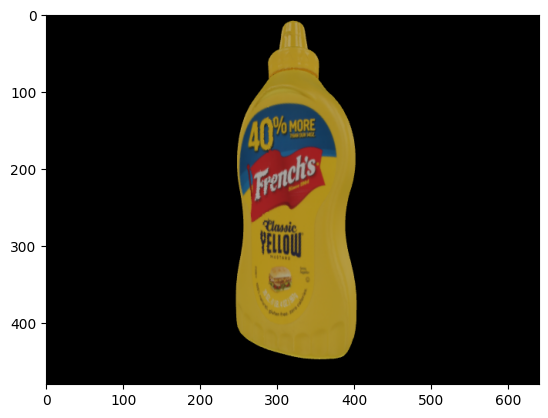

0.00019296
[[-0.987226   -0.04180355  0.15374422 -0.0320412 ]
 [-0.1539462   0.00163698 -0.98807787  0.00841793]
 [ 0.04105349 -0.99912451 -0.00805156  0.23981304]
 [ 0.          0.          0.          1.        ]]


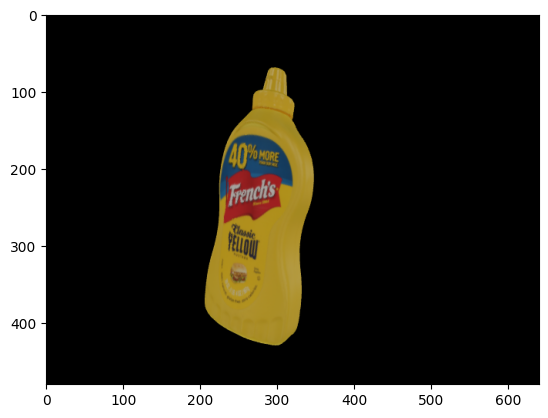

0.000126806
[[-0.94923066 -0.08328818  0.30335497 -0.06408239]
 [-0.30415773 -0.0031825  -0.95261637  0.01683586]
 [ 0.08030711 -0.99652042 -0.02231182  0.28316282]
 [ 0.          0.          0.          1.        ]]


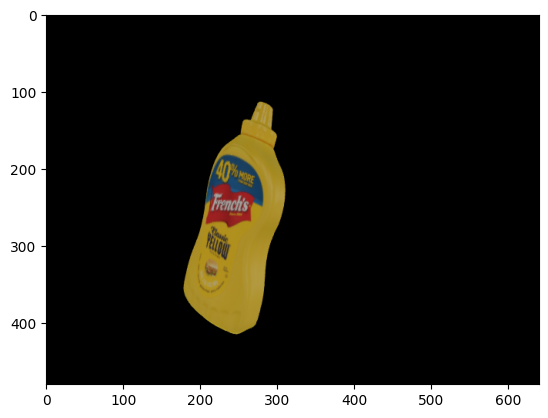

0.00015008
[[-0.88698557 -0.12339305  0.44500646 -0.09612359]
 [-0.44679344 -0.01433517 -0.89452229  0.02525379]
 [ 0.11675708 -0.99225433 -0.04241612  0.3265126 ]
 [ 0.          0.          0.          1.        ]]


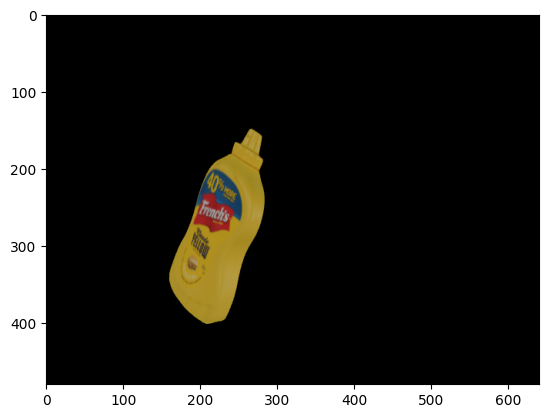

0.000114075
[[-0.80208245 -0.16109263  0.57507644 -0.12816479]
 [-0.57820591 -0.03153586 -0.81528119  0.03367172]
 [ 0.14947132 -0.98643533 -0.06785035  0.36986238]
 [ 0.          0.          0.          1.        ]]


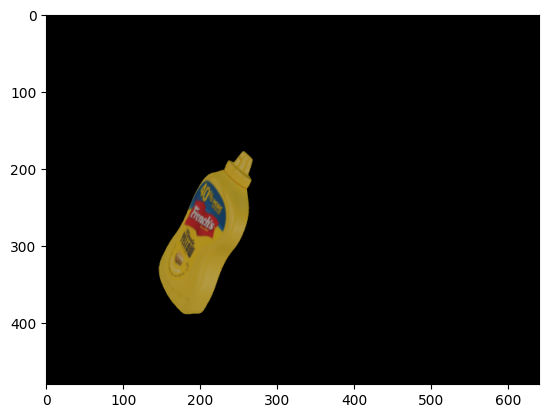

In [23]:
import torch
import numpy as np
import cv2

from pytorch3d.ops import efficient_pnp
from pytorch3d.renderer.cameras import look_at_view_transform
from pytorch3d.transforms import axis_angle_to_matrix
from pytorch3d.renderer import PerspectiveCameras
from posingpixels.utils.geometry import apply_pose_to_points, render_points_in_2d


cvcam_in_glcam = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

x = (
    torch.tensor(tracker.unposed_3d_points, dtype=torch.float32)
    .to(device)
    .unsqueeze(0)
    .repeat(40, 1, 1)
)
y = pred_tracks_original.detach().clone().squeeze(0)[:40]
# solution = efficient_pnp(x, y)

for i in range(5):
    gt = tracker.get_gt_pose(i)
    K_np = tracker.K
    x_np = x[i].cpu().numpy()
    x_posed = apply_pose_to_points(x_np, gt[:3, :3], gt[:3, 3])
    y_np = render_points_in_2d(x_posed, K_np)
    # Time the operation
    start = cv2.getTickCount()
    _, R, T = cv2.solvePnP(x_np, y_np, K_np, distCoeffs=None, flags=cv2.SOLVEPNP_EPNP)
    end = cv2.getTickCount()
    print((end - start) / cv2.getTickFrequency())
    R = cv2.Rodrigues(R)[0]
    pose = np.eye(4)
    pose[:3, :3] = R
    pose[:3, 3] = T.squeeze()
    
    print(pose)

    rgb, depth = tracker.dataset.render_mesh_at_pose(pose)
    rgb_gt = tracker.dataset.render_mesh_at_pose(gt)[0]
    rgb_avg = cv2.addWeighted(rgb, 0.5, rgb_gt, 0.5, 0)
    plt.imshow(rgb_avg)
    # plt.imshow(rgb)
    plt.show()


tensor([[[-9.9998e-01, -2.2923e-04, -6.9967e-03],
         [ 6.9967e-03, -1.3254e-03, -9.9998e-01],
         [ 2.1998e-04, -1.0000e+00,  1.3270e-03]]], device='cuda:0') tensor([[-1.4122e-04,  1.8978e-05,  1.9653e-01]], device='cuda:0')


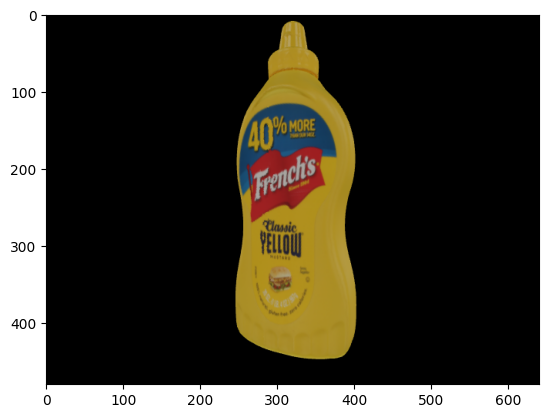

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/pytorch3d/ops/perspective_n_points.py:160: UserWarning: 
EPnP: 0.50% points have z<0.
  warnings.warn("\nEPnP: %2.2f%% points have z<0." % (neg_rate * 100.0))


tensor([[[-0.9880, -0.1544,  0.0064],
         [-0.0060, -0.0026, -1.0000],
         [ 0.1544, -0.9880,  0.0016]]], device='cuda:0') tensor([[-0.0330,  0.0085,  0.2411]], device='cuda:0')


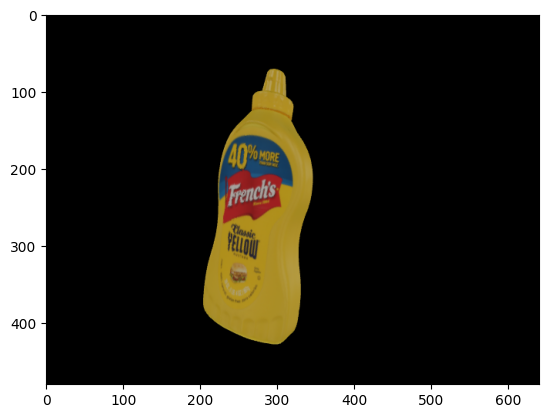

tensor([[[-0.9497, -0.3040,  0.0747],
         [-0.0772, -0.0037, -0.9970],
         [ 0.3034, -0.9527, -0.0200]]], device='cuda:0') tensor([[-0.0643,  0.0169,  0.2836]], device='cuda:0')


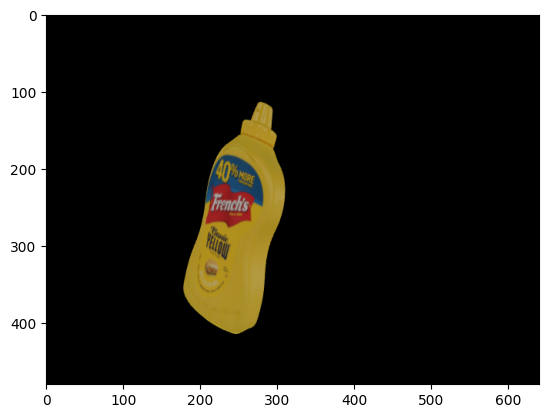

tensor([[[-0.8867, -0.4466,  0.1200],
         [-0.1265, -0.0154, -0.9919],
         [ 0.4448, -0.8946, -0.0428]]], device='cuda:0') tensor([[-0.0960,  0.0253,  0.3264]], device='cuda:0')


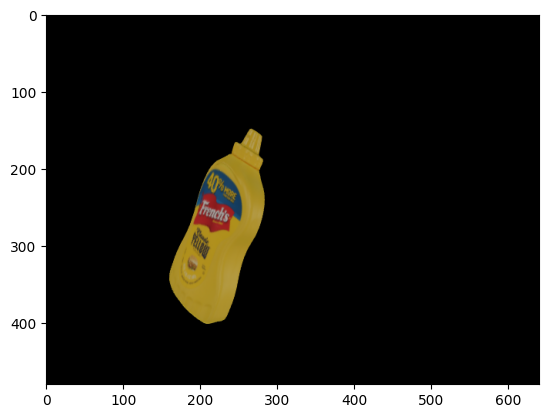

tensor([[[-0.8034, -0.5705,  0.1706],
         [-0.1676, -0.0583, -0.9841],
         [ 0.5714, -0.8192, -0.0487]]], device='cuda:0') tensor([[-0.1281,  0.0342,  0.3701]], device='cuda:0')


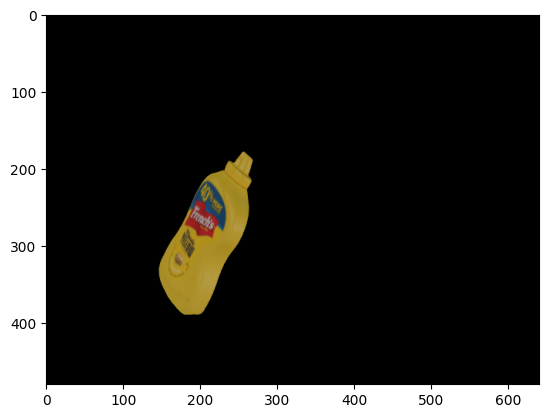

tensor([[[-0.6917, -0.7173, -0.0839],
         [-0.0984,  0.2086, -0.9730],
         [ 0.7155, -0.6648, -0.2149]]], device='cuda:0') tensor([[-0.1516,  0.0341,  0.3866]], device='cuda:0')


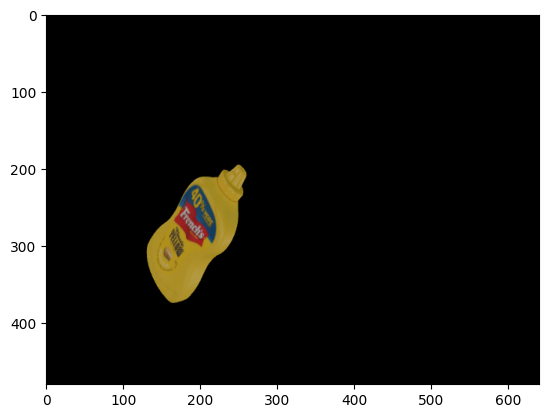

tensor([[[-0.5723, -0.7908,  0.2172],
         [-0.2335, -0.0968, -0.9675],
         [ 0.7861, -0.6044, -0.1293]]], device='cuda:0') tensor([[-0.1917,  0.0507,  0.4557]], device='cuda:0')


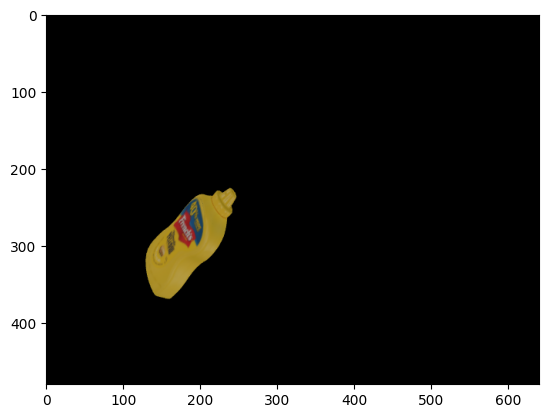

tensor([[[-0.4371, -0.8812,  0.1804],
         [-0.2421, -0.0779, -0.9671],
         [ 0.8662, -0.4664, -0.1793]]], device='cuda:0') tensor([[-0.2247,  0.0582,  0.5004]], device='cuda:0')


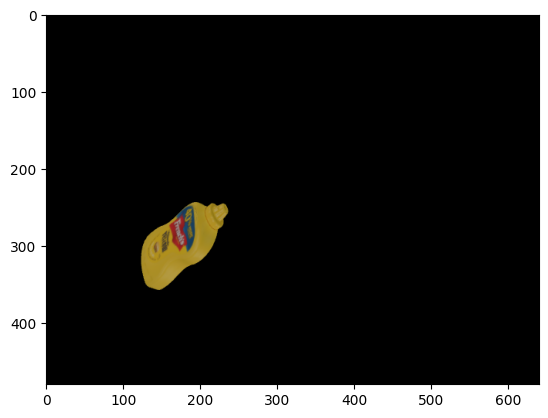

tensor([[[-0.2930, -0.9330,  0.2089],
         [-0.2415, -0.1392, -0.9604],
         [ 0.9251, -0.3318, -0.1846]]], device='cuda:0') tensor([[-0.2622,  0.0684,  0.5539]], device='cuda:0')


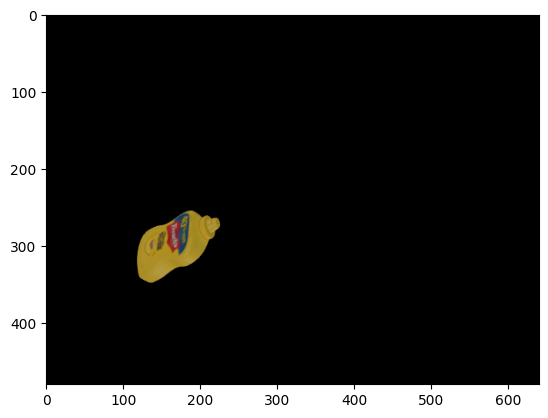

tensor([[[-0.1141, -0.9308,  0.3474],
         [-0.3231, -0.2959, -0.8989],
         [ 0.9395, -0.2148, -0.2670]]], device='cuda:0') tensor([[-0.2747,  0.0749,  0.5614]], device='cuda:0')


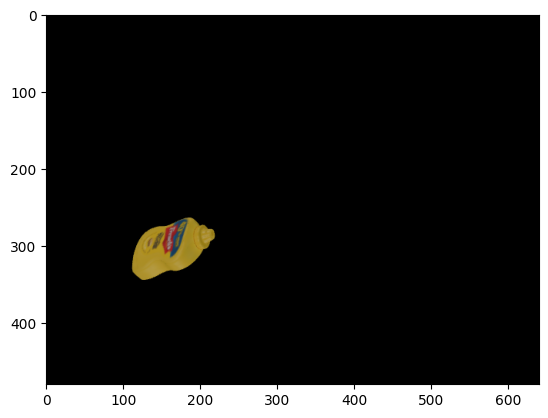

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/pytorch3d/ops/perspective_n_points.py:160: UserWarning: 
EPnP: 42.57% points have z<0.
  warnings.warn("\nEPnP: %2.2f%% points have z<0." % (neg_rate * 100.0))


tensor([[[ 0.0473, -0.9047,  0.4235],
         [-0.3027, -0.4170, -0.8570],
         [ 0.9519, -0.0877, -0.2936]]], device='cuda:0') tensor([[-0.2935,  0.0816,  0.5794]], device='cuda:0')


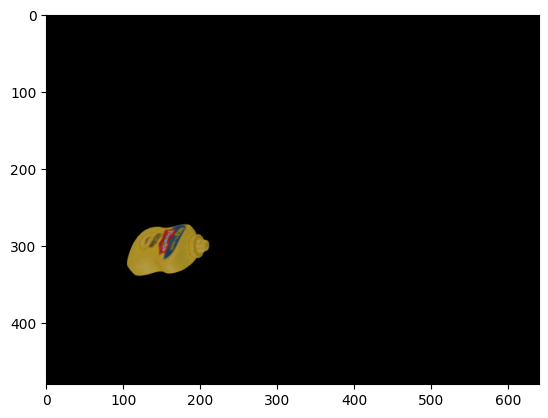

tensor([[[ 1.5649e-01, -9.8768e-01, -6.4486e-04],
         [-3.6492e-01, -5.7211e-02, -9.2928e-01],
         [ 9.1779e-01,  1.4566e-01, -3.6938e-01]]], device='cuda:0') tensor([[-0.3428,  0.0861,  0.6582]], device='cuda:0')


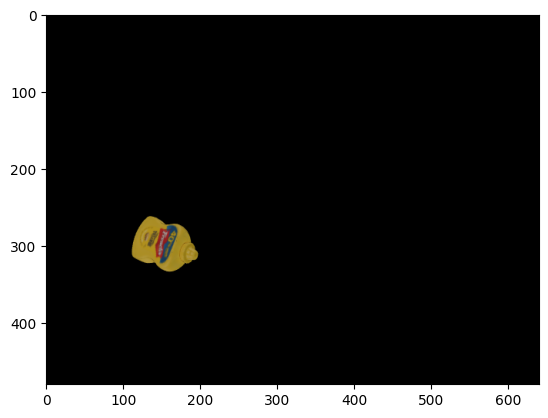

tensor([[[ 0.3377, -0.9247,  0.1760],
         [-0.3020, -0.2835, -0.9102],
         [ 0.8915,  0.2542, -0.3750]]], device='cuda:0') tensor([[-0.3812,  0.0998,  0.7115]], device='cuda:0')


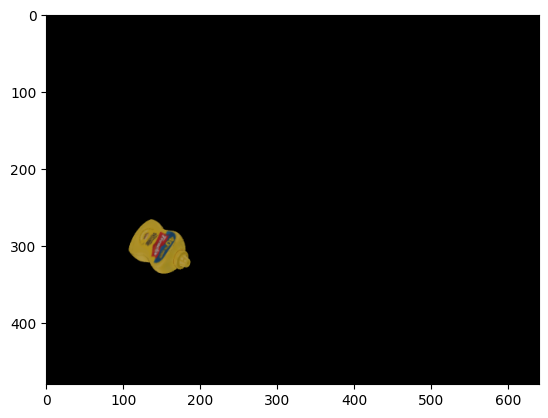

tensor([[[ 0.4916, -0.8517,  0.1817],
         [-0.2531, -0.3394, -0.9060],
         [ 0.8332,  0.3994, -0.3824]]], device='cuda:0') tensor([[-0.4238,  0.1110,  0.7723]], device='cuda:0')


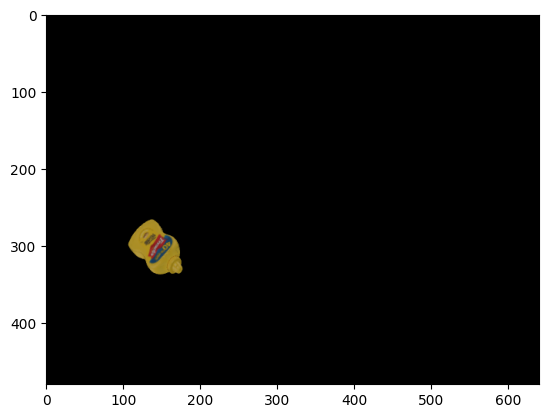

tensor([[[ 0.6255, -0.7663,  0.1468],
         [-0.2378, -0.3664, -0.8996],
         [ 0.7431,  0.5277, -0.4114]]], device='cuda:0') tensor([[-0.4567,  0.1194,  0.8172]], device='cuda:0')


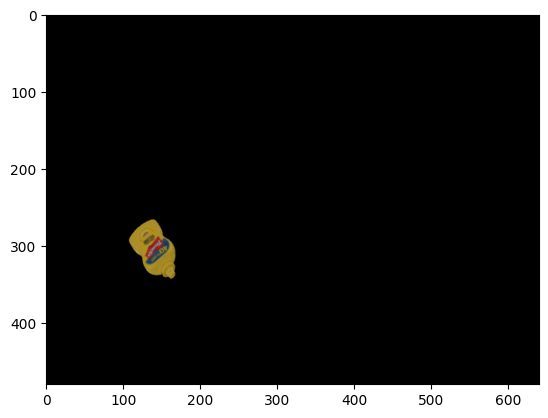

In [ ]:
for i in range(15):
    pytorch_K = torch.eye(4)
    pytorch_K[:3, :3] = torch.tensor(tracker.K)
    pytorch_K = pytorch_K.to(device).float()
    f = torch.tensor([pytorch_K[0, 0], pytorch_K[1, 1]]).to(device).unsqueeze(0)
    p = torch.tensor([pytorch_K[0, 2], pytorch_K[1, 2]]).to(device).unsqueeze(0)
    camera = PerspectiveCameras(
        device=device,
        R=torch.eye(3).unsqueeze(0),
        T=torch.tensor([0, 0, 0.0]).unsqueeze(0),
        # K=pytorch_K.unsqueeze(0),
        focal_length=f,
        principal_point=p,
        in_ndc=False,
        image_size=torch.tensor((tracker.H, tracker.W)).to(device).unsqueeze(0),
    )
    gt_pose = torch.tensor(tracker.get_gt_pose(i)).float().to(device)
    posed_points = apply_pose_to_points(x[i], gt_pose[:3, :3], gt_pose[:3, 3])
    # rendered_points = render_points_in_2d(posed_points, pytorch_K[:3, :3]).unsqueeze(0)
    rendered_points = camera.transform_points_screen(posed_points.unsqueeze(0))
    num_batch = rendered_points.shape[0]
    num_pts = rendered_points.shape[1]
    
    p3d = posed_points
    p2d_h = torch.cat((rendered_points[..., :2], torch.ones(num_batch, num_pts, 1).to(device)), dim=-1)
    pytorch_K[0, 0] = - pytorch_K[0, 0]
    pytorch_K[1, 1] = - pytorch_K[1, 1]
    p_inv = torch.inverse(pytorch_K[:3, :3]).T
    p2d_uncal = torch.matmul(p2d_h, p_inv.unsqueeze(0))
    transform = efficient_pnp(x[i].unsqueeze(0), p2d_uncal[..., :2])
    
    print(transform.R, transform.T)
    
    pose = torch.eye(4).to(device)
    pose[:3, :3] = transform.R.squeeze().T
    pose[:3, 3] = transform.T.squeeze()
    rgb, _ = tracker.dataset.render_mesh_at_pose(pose.detach().cpu().numpy())
    rgb_gt, _ = tracker.dataset.render_mesh_at_pose(pose.detach().cpu().numpy())
    rgb_avg = cv2.addWeighted(rgb, 0.5, rgb_gt, 0.5, 0)
    plt.imshow(rgb_avg)
    # plt.imshow(rgb)
    plt.show()

In [ ]:
[[-0.80208245 -0.16109263  0.57507644 -0.12816479]
 [-0.57820591 -0.03153586 -0.81528119  0.03367172]
 [ 0.14947132 -0.98643533 -0.06785035  0.36986238]
 [ 0.          0.          0.          1.        ]]

In [ ]:
##########################################################################################
##########################################################################################
##########################################################################################

# create camera
#
# camera_pos        [3]         xyz
# img_size          scalar      image size
# focal_length      scalar      focal length
def make_camera(camera_pos, img_size, focal_length, DEVICE):
    r, t = look_at_view_transform(dist=camera_pos[2], elev=0, azim=0)

    # create projection matrix according to pytorch3d convention. Under PerspectiveCameras
    # https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/renderer/cameras.html
    p_matrix = np.array(
        [
            focal_length,
            0.0,
            img_size // 2,
            0.0,
            0.0,
            focal_length,
            img_size // 2,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            0.0,
            0.0,
            1.0,
            0.0,
        ],
        dtype=np.float32,
    ).reshape(4, 4)
    p_matrix = torch.tensor(p_matrix).float().unsqueeze(0)

    cameras = PerspectiveCameras(
        device=DEVICE,
        R=r,
        T=t,
        K=p_matrix,
        in_ndc=False,
        image_size=(img_size, img_size),
    )

    return cameras


# create intrinsic camera matrix from focal length and image width/height
def make_intrinsic_matrix(img_size, focal):
    s = img_size // 2
    p_matrix = np.array([focal, 0.0, s, 0.0, focal, s, 0.0, 0.0, 1.0], dtype=np.float32)

    return torch.tensor(p_matrix.reshape(3, 3))


###################################################################
if __name__ == "__main__":
    # create camera parameters
    IMG_SIZE = 256
    CAMERA_POS = [0.0, 0.0, -20.0]
    FOCAL_LENGTH = 2000
    DEVICE = "cuda"

    # create dummy points
    q = (
        torch.tensor(
            [
                [0, 0, 0],
                [0, 0.3, 1],
                [0, 1, 0],
                [1, 0, 0],
                [0, 0, -1],
                [0, -1, 0],
                [-1, 0, 0],
            ]
        )
        .float()
        .cuda()
        .unsqueeze(0)
    )

    # create camera used for rendering
    cam = make_camera(CAMERA_POS, IMG_SIZE, FOCAL_LENGTH, DEVICE)

    # create constants
    P_MAT = make_intrinsic_matrix(IMG_SIZE, -FOCAL_LENGTH).to(DEVICE)
    K = np.ascontiguousarray(P_MAT.detach().cpu().numpy()).reshape((3, 3))

    # create custom rotation and translation and apply to get 3d and 2d points
    axis_angle = (
        torch.tensor([np.pi / 4.0, -np.pi / 4.0, np.pi / 4.0])
        .float()
        .unsqueeze(0)
        .cuda()
    )
    my_R = axis_angle_to_matrix(axis_angle).permute(0, 2, 1)
    my_T = torch.tensor([0.0, 0.3, 0.5]).float().unsqueeze(0).cuda()
    q_rt = torch.matmul(q, my_R) + my_T.unsqueeze(1)
    b = cam.transform_points_screen(q_rt)
    num_batch = b.shape[0]
    num_pts = b.shape[1]

    # find rotation and translation
    # opencv
    p3d = q.detach().cpu().numpy()
    p2d = b[..., :2].detach().cpu().numpy()
    for i in range(num_batch):
        p = np.ascontiguousarray(p2d[i].reshape((num_pts, 1, 2)))
        p_z = np.ascontiguousarray(p3d[0])
        _, R, T = cv2.solvePnP(p_z, p, K, distCoeffs=None, flags=cv2.SOLVEPNP_EPNP)
        print("opencv predicted rot: ", cv2.Rodrigues(-R)[0])
        print("opencv precicted trans: ", T)

    # find rotation and translation
    # pytorch3d
    P_MAT = make_intrinsic_matrix(IMG_SIZE, -FOCAL_LENGTH).to(DEVICE)
    p3d = q_rt
    p2d_h = torch.cat(
        (b[..., :2], torch.ones(num_batch, num_pts, 1).to(b.device)), dim=-1
    )
    p_inv = torch.inverse(P_MAT).T
    p2d_uncal = torch.matmul(p2d_h, p_inv.unsqueeze(0))
    transform = efficient_pnp(q.repeat(num_batch, 1, 1), p2d_uncal[..., :2])
    print(transform.R)
    print(transform.T)

    print("done")

    print(tracker.K)

opencv predicted rot:  [[ 0.47259788  0.30091149  0.82831366]
 [-0.82831364  0.47259789  0.30091153]
 [-0.30091155 -0.82831365  0.47259785]]
opencv precicted trans:  [[-1.71837947e-10]
 [ 3.00000002e-01]
 [ 2.05000006e+01]]
opencv predicted rot:  [[ 0.47259788  0.30091149  0.82831366]
 [-0.82831364  0.47259789  0.30091153]
 [-0.30091155 -0.82831365  0.47259785]]
opencv precicted trans:  [[-1.71837947e-10]
 [ 3.00000002e-01]
 [ 2.05000006e+01]]
tensor([[[ 0.4726,  0.3009,  0.8283],
         [-0.8283,  0.4726,  0.3009],
         [-0.3009, -0.8283,  0.4726]],

        [[ 0.4726,  0.3009,  0.8283],
         [-0.8283,  0.4726,  0.3009],
         [-0.3009, -0.8283,  0.4726]]], device='cuda:0')
tensor([[4.2841e-07, 3.0000e-01, 2.0500e+01],
        [4.2841e-07, 3.0000e-01, 2.0500e+01]], device='cuda:0')
done
[[319.58200073   0.         320.21498477]
 [  0.         417.11868286 244.34866809]
 [  0.           0.           1.        ]]


In [8]:
cv2.solvePnP?

Docstring:
solvePnP(objectPoints, imagePoints, cameraMatrix, distCoeffs[, rvec[, tvec[, useExtrinsicGuess[, flags]]]]) -> retval, rvec, tvec
.   @brief Finds an object pose from 3D-2D point correspondences.
.   
.   @see @ref calib3d_solvePnP
.   
.   This function returns the rotation and the translation vectors that transform a 3D point expressed in the object
.   coordinate frame to the camera coordinate frame, using different methods:
.   - P3P methods (@ref SOLVEPNP_P3P, @ref SOLVEPNP_AP3P): need 4 input points to return a unique solution.
.   - @ref SOLVEPNP_IPPE Input points must be >= 4 and object points must be coplanar.
.   - @ref SOLVEPNP_IPPE_SQUARE Special case suitable for marker pose estimation.
.   Number of input points must be 4. Object points must be defined in the following order:
.     - point 0: [-squareLength / 2,  squareLength / 2, 0]
.     - point 1: [ squareLength / 2,  squareLength / 2, 0]
.     - point 2: [ squareLength / 2, -squareLength / 2, 0]
.     - poi